Objective:- To find the best model with highest accuracy for k-NN using amazon fine food reviews dataset.

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import re, gensim
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
import os

C:\Users\pavan\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\pavan\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:

#choosing only positive and negative reviews not neutral reviews.

# using the SQLite Table to read data.
con = sqlite3.connect('C:\\Users\\pavan\\Desktop\\Applied AI course\\AmazonFineFoodReviews-I\\database.sqlite') 
filtered_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [3]:
#Removing duplicate entries
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True,\
                                      inplace=False, kind='quicksort',\
                                      na_position='last')
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},\
                                  keep='first', inplace=False)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

(364171, 10)

In [4]:
#Sorting data on the basis of TIME

final = final[:30000]
final = final.sort_values(by=['Time'], axis=0)
final.shape

(30000, 10)

In [5]:

"""
This code snippet does text preprocessing
"""
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
final_text = []
for index in range(len(final['Text'])):
    filtered_sentence=[]
    sent=cleanhtml(final['Text'].iloc[index]) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():# clean punctuation marks from words
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                cleaned_words = cleaned_words.lower()
                if(cleaned_words not in stop):# blocks stopwords
                    s=(sno.stem(cleaned_words))# stemming in process
                    filtered_sentence.append(s)
                else:
                    continue
            else:
                continue 
    str1 = " ".join(filtered_sentence) #final cleaned string of words
    final_text.append(str1)

In [6]:
amazon_data_text = pd.Series(final_text)
amazon_data_label = pd.Series(final['Score'])
print(amazon_data_text.shape)
print(amazon_data_label.shape)

(30000,)
(30000,)


In [7]:
"""
Spliting sample data into train_data and test_data (70:30)
"""
x_train, x_test, y_train, y_test = cross_validation.train_test_split(\
                                                                     amazon_data_text,\
                                                                     amazon_data_label,\
                                                                     test_size = 0.30,\
                                                                     random_state=0)

In [8]:

print(y_test.value_counts())

positive    7622
negative    1378
Name: Score, dtype: int64


In [9]:
"""
This code snippet converts train data from text to vectors by BOW.
"""
count_vect = CountVectorizer(analyzer='word') #in scikit-learn
bow_text_train_vector = count_vect.fit_transform(x_train)
bow_text_train_vector = bow_text_train_vector
bow_text_train_vector.shape


(21000, 19818)

In [10]:
"""
This code snippet converts test data from text to vectors by BOW.
"""
bow_text_test_vector = count_vect.transform(x_test)
bow_text_test_vector = bow_text_test_vector
print(bow_text_test_vector.shape)

(9000, 19818)



The optimal number of neighbors is 8.


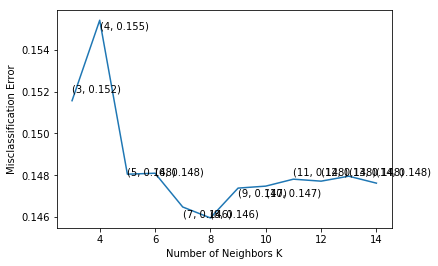

the misclassification error for each k value is :  [0.152 0.155 0.148 0.148 0.146 0.146 0.147 0.147 0.148 0.148 0.148 0.148]


In [11]:
# empty list that will hold cv scores
cv_scores = []
k_values = list(range(3,15))
# perform 10-fold cross validation
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, bow_text_train_vector, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
bow_optimal_k = k_values[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % bow_optimal_k)

# plot misclassification error vs k 
plt.plot(k_values, MSE)

for xy in zip(k_values, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [12]:
#Apply k-NN for BoW(brute force)

# Instantiate learning model
knn_brute = KNeighborsClassifier(n_neighbors= bow_optimal_k, algorithm = 'brute')
# fitting the model
knn_brute.fit(bow_text_train_vector, y_train)
# response prediction
pred = knn_brute.predict(bow_text_test_vector)
# evaluate accuracy
acc = accuracy_score(y_test, pred)*100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (bow_optimal_k, acc))



The accuracy of the knn classifier for k = 8 is 84.955556%


In [13]:
#Apply k-NN for BoW(kd tree)

# Instantiate learning model
knn_brute = KNeighborsClassifier(n_neighbors= bow_optimal_k, algorithm = 'kd_tree')
# fitting the model
knn_brute.fit(bow_text_train_vector, y_train)
# response prediction
pred = knn_brute.predict(bow_text_test_vector)
# evaluate accuracy
acc = accuracy_score(y_test, pred)*100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (bow_optimal_k, acc))


C:\Users\pavan\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:212: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "



The accuracy of the knn classifier for k = 8 is 84.955556%


Observation:-
- Here we applied Bag of Words to convert text to vector
- Here we got best hyperparameter for k-NN modl is 8
- After applying the above hyperparameter in k-NN we got accuracy of 84.955556%.

In [14]:
#Converts train data from text to vectors by TF_IDF.

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf_train = tf_idf_vect.fit_transform(x_train)
final_tf_idf_train.shape

(21000, 430451)

In [15]:
#Converts test data from text to vectors by TF_IDF.

final_tf_idf_test = tf_idf_vect.transform(x_test)
final_tf_idf_test.shape

(9000, 430451)


The optimal number of neighbors is 10.


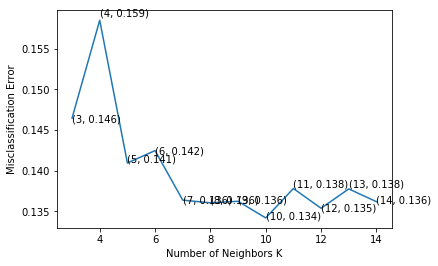

the misclassification error for each k value is :  [0.146 0.159 0.141 0.142 0.136 0.136 0.136 0.134 0.138 0.135 0.138 0.136]


In [16]:
# empty list that will hold cv scores
cv_scores = []
k_values = list(range(3,15))
# perform 10-fold cross validation
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, final_tf_idf_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
tf_idf_optimal_k = k_values[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % tf_idf_optimal_k)

# plot misclassification error vs k 
plt.plot(k_values, MSE)

for xy in zip(k_values, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()
print("the misclassification error for each k value is : ", np.round(MSE,3))

In [17]:
#Apply k-NN for tf_idf(brute force)

# Instantiate learning model
knn_brute = KNeighborsClassifier(n_neighbors= tf_idf_optimal_k, algorithm = 'brute')
# fitting the model
knn_brute.fit(final_tf_idf_train, y_train)
# response prediction
pred = knn_brute.predict(final_tf_idf_test)
# evaluate accuracy
acc = accuracy_score(y_test, pred)*100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (tf_idf_optimal_k, acc))



The accuracy of the knn classifier for k = 10 is 86.344444%


In [18]:
#Apply k-NN for tf_idf(kd tree)

# Instantiate learning model
kd_tree = KNeighborsClassifier(n_neighbors= tf_idf_optimal_k, algorithm = 'kd_tree')
# fitting the model
kd_tree.fit(final_tf_idf_train, y_train)
# response prediction
pred = kd_tree.predict(final_tf_idf_test)
# evaluate accuracy
acc = accuracy_score(y_test, pred)*100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (tf_idf_optimal_k, acc))


C:\Users\pavan\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:212: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "



The accuracy of the knn classifier for k = 10 is 86.344444%


Observation:-
- Here we applied tf-idf to convert text to vector.
- Here we got best hyperparameter for the k-NN model is 10.
- After applying above hyperparameter in k-NN we got accuracy of 86.240000%.

In [19]:

#Creating own vocabulary of words from reviews.

i=0
list_of_train_sent=[]
for sent in x_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_train_sent.append(filtered_sentence)
w2v_train_model=gensim.models.Word2Vec(list_of_train_sent,min_count=5,size=50, workers=4)
i=0
list_of_test_sent=[]
for sent in x_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_test_sent.append(filtered_sentence)
w2v_test_model=gensim.models.Word2Vec(list_of_test_sent,min_count=5,size=50, workers=4)

In [20]:
#Converts train data from text to vectors by Average Word2Vec

# compute average word2vec for each review.
tain_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_train_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_train_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    if cnt_words == 0:
        cnt_words = 1
    sent_vec /= cnt_words
    tain_vectors.append(sent_vec)
train_avg_w2v = np.asmatrix(tain_vectors)
train_avg_w2v.shape

(21000, 50)

In [21]:
#Converts test data from text to vectors by Average Word2Vec

# compute average word2vec for each review.
test_vectors = []; # the avg-w2v for each sentence.
for sent in list_of_test_sent: 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; 
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_test_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    if cnt_words == 0:
        cnt_words = 1
    sent_vec /= cnt_words
    test_vectors.append(sent_vec)
test_avg_w2v = np.asmatrix(test_vectors)
test_avg_w2v.shape

(9000, 50)


The optimal number of neighbors is 14.


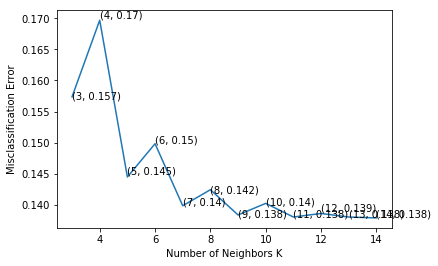

the misclassification error for each k value is :  [0.157 0.17  0.145 0.15  0.14  0.142 0.138 0.14  0.138 0.139 0.138 0.138]


In [22]:
# empty list that will hold cv scores
cv_scores = []
k_values = list(range(3,15))
# perform 10-fold cross validation
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, train_avg_w2v, y_train, cv= 10, scoring='accuracy')
    cv_scores.append(scores.mean())
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = k_values[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(k_values, MSE)

for xy in zip(k_values, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()
print("the misclassification error for each k value is : ", np.round(MSE,3))

In [23]:
#Apply k-NN for avg_w2vec(brute force)

# Instantiate learning model
knn_brute = KNeighborsClassifier(n_neighbors= optimal_k, algorithm = 'brute')
# fitting the model
knn_brute.fit(train_avg_w2v, y_train)
# response prediction
pred = knn_brute.predict(test_avg_w2v)
# evaluate accuracy
acc = accuracy_score(y_test, pred)*100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))



The accuracy of the knn classifier for k = 14 is 83.077778%


In [24]:
#Apply k-NN for avg_w2vec(kd tree)

# Instantiate learning model
kd_tree = KNeighborsClassifier(n_neighbors= optimal_k, algorithm = 'kd_tree')
# fitting the model
kd_tree.fit(train_avg_w2v, y_train)
# response prediction
pred = kd_tree.predict(test_avg_w2v)
# evaluate accuracy
acc = accuracy_score(y_test, pred)*100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))



The accuracy of the knn classifier for k = 14 is 83.077778%


- Here we applied average word2vec to convert text to vector.
- Here we got best hyperparameter for the k-NN model is 13.
- After applying above hyperparameter in k-NN we got accuracy of 82.6266667%.

Conclusion:-
    - From the above analysis with 30000 sample data points, So I got that TF-IDF is best accuracy with 86.240000%.